In [ ]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

selected_etfs = ['IEMG', 'EEM', 'ARKK', 'ARKW', 'TLT', 'SPTL', 'SHY', 'VGSH','SOXX', 'ITA']


prices = yf.download(selected_etfs, start = '2015-01-01', end = '2024-12-31')['Close']

train_cutoff = pd.Timestamp("2020-01-01")

prices = prices.dropna()
all_pairs = [('IEMG', 'EEM'), ('ARKK', 'ARKW'), ('TLT', 'SPTL'), ('SHY', 'VGSH'),('SOXX', 'ITA')]

prices.info()


C:\Users\anair26\AppData\Local\Temp\ipykernel_21300\4010936096.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(selected_etfs, start = '2015-01-01', end = '2019-12-31')['Close']
[*********************100%***********************]  10 of 10 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2015-01-02 to 2019-12-30
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ARKK    1257 non-null   float64
 1   ARKW    1257 non-null   float64
 2   EEM     1257 non-null   float64
 3   IEMG    1257 non-null   float64
 4   ITA     1257 non-null   float64
 5   SHY     1257 non-null   float64
 6   SOXX    1257 non-null   float64
 7   SPTL    1257 non-null   float64
 8   TLT     1257 non-null   float64
 9   VGSH    1257 non-null   float64
dtypes: float64(10)
memory usage: 108.0 KB


In [3]:
def generate_labels(z, upper=1.5, lower=-1.5):
    return np.where(z > upper, -1,    # SHORT spread
           np.where(z < lower, 1,     # LONG spread
           0))                        # No trade



In [4]:
import pandas as pd
import statsmodels.api as sm

# Assumes `prices` is your DataFrame of adjusted-close prices,
# and `all_pairs` is a list of tuples: [(etf1, etf2), …]

lookback = 30
spread_records = []

for etf_a, etf_b in all_pairs:
    # Align prices and drop any NaNs for the pair
    pair_prices = pd.concat([prices[etf_a], prices[etf_b]], axis=1).dropna()
    a = pair_prices[etf_a]
    b = pair_prices[etf_b]

    # 1) Estimate hedge ratio via OLS
    model = sm.OLS(a, sm.add_constant(b)).fit()
    hedge_ratio = model.params[etf_b]

    # 2) Compute spread and rolling statistics
    spread = a - hedge_ratio * b
    rolling_mean = spread.rolling(window=lookback).mean()
    rolling_std = spread.rolling(window=lookback).std()
    z_score = (spread - rolling_mean) / rolling_std
    rolling_volatility = z_score.rolling(window=lookback).std()

    # 3) Build DataFrame for this pair
    df_pair = pd.DataFrame({
        'Date': spread.index,
        'pair': f"{etf_a}-{etf_b}",
        'spread': spread,
        'rolling_mean': rolling_mean,
        'rolling_std': rolling_std,
        'z_score': z_score,
        'rolling_volatility': rolling_volatility
    })

    spread_records.append(df_pair)

# Combine all pairs into a single long-form DataFrame
spread_long = pd.concat(spread_records, ignore_index=True)

# label feature
spread_long['label'] = generate_labels(spread_long['z_score'])

# 4) Add lagged features for z_score and spread
spread_long['z_score_lag1'] = spread_long.groupby('pair')['z_score'].shift(1)
spread_long['spread_lag1'] = spread_long.groupby('pair')['spread'].shift(1)

spread_long['z_score_lag2'] = spread_long.groupby('pair')['z_score'].shift(2)
spread_long['spread_lag2'] = spread_long.groupby('pair')['spread'].shift(2)

spread_long['z_score_lag3'] = spread_long.groupby('pair')['z_score'].shift(3)
spread_long['spread_lag3'] = spread_long.groupby('pair')['spread'].shift(3)


# 5) Final cleanup
spread_long.dropna(inplace=True)
spread_long.sort_values(['pair', 'Date'], inplace=True)
spread_long.reset_index(drop=True, inplace=True)

# `spread_long` now contains columns:
# ['Date', 'pair', 'spread', 'rolling_mean', 'rolling_std',
#  'z_score', 'rolling_volatility', 'z_score_lag1', 'spread_lag1']


spread_long.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5995 entries, 0 to 5994
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                5995 non-null   datetime64[ns]
 1   pair                5995 non-null   object        
 2   spread              5995 non-null   float64       
 3   rolling_mean        5995 non-null   float64       
 4   rolling_std         5995 non-null   float64       
 5   z_score             5995 non-null   float64       
 6   rolling_volatility  5995 non-null   float64       
 7   label               5995 non-null   int64         
 8   z_score_lag1        5995 non-null   float64       
 9   spread_lag1         5995 non-null   float64       
 10  z_score_lag2        5995 non-null   float64       
 11  spread_lag2         5995 non-null   float64       
 12  z_score_lag3        5995 non-null   float64       
 13  spread_lag3         5995 non-null   float64     

In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 


le_pairs = LabelEncoder()
spread_long['pair_encoded'] = le_pairs.fit_transform(spread_long['pair'])

print(spread_long['pair_encoded'])


0       0
1       0
2       0
3       0
4       0
       ..
5990    4
5991    4
5992    4
5993    4
5994    4
Name: pair_encoded, Length: 5995, dtype: int64


In [ ]:
features = [
    'pair_encoded','z_score_lag1','rolling_std','rolling_mean',
    'spread','spread_lag1','z_score','rolling_volatility',
    'spread_lag2','spread_lag3','z_score_lag2','z_score_lag3'
    ]
target = 'label'


train_spread_long = spread_long[spread_long['Date'] < train_cutoff]
test_spread_long = spread_long[spread_long['Date'] >= train_cutoff]


X = train_spread_long[features]
y_nolabel = train_spread_long[target]

label_map = {-1: 0, 0: 1, 1: 2}
y = y_nolabel.map(label_map)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # shuffle=False preserves time order
)


In [43]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


model = xgb.XGBClassifier(
    objective='multi:softprob',  # For multi-class (long, short, neutral)
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False
)

param_grid = {
    'n_estimators':    [50, 100, 200],
    'max_depth':       [3, 5, 7],
    'learning_rate':   [0.01, 0.1, 0.2],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',    # or your custom backtest metric
    cv=3,                  # e.g. 3-fold CV (use TimeSeriesSplit for time series)
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

y_pred = best_model.predict(X_test)

inv_map = {v:k for k,v in label_map.items()}
y_pred_original = pd.Series(y_pred).map(inv_map)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.6}
Best CV score: 0.9981236969392896


c:\Users\anair26\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:10:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


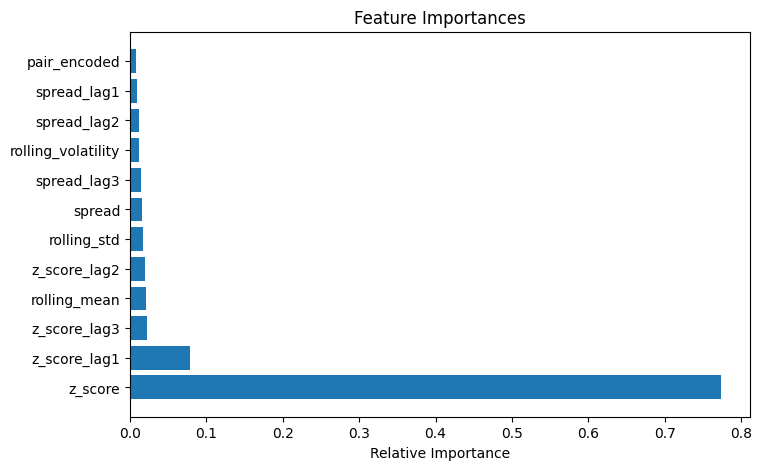

[0.00752808 0.0092342  0.01107765 0.0111385  0.0137138  0.0156497
 0.01646168 0.01952847 0.02146657 0.02250929 0.07838622 0.7733059 ]


In [44]:
def feature_importance(Model,feature_df):

    fi = Model.feature_importances_
    feat_names = feature_df.columns

    # Create a sorted bar chart
    indices = np.argsort(fi)[::-1]
    plt.figure(figsize=(8,5))
    plt.barh(feat_names[indices], fi[indices])
    plt.title("Feature Importances")
    plt.xlabel("Relative Importance")
    plt.show()

    print(np.sort(fi))

feature_importance(best_model,X)

In [45]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       106
           1       1.00      1.00      1.00       992
           2       1.00      0.99      1.00       101

    accuracy                           1.00      1199
   macro avg       1.00      1.00      1.00      1199
weighted avg       1.00      1.00      1.00      1199



In [46]:
# re-train with edited features

newdict = dict(zip(feat_names,fi))

for k in list(newdict):        # list() so we can delete while iterating
    if newdict[k] <= np.float32(0.02):
        del newdict[k]


features = list(newdict.keys())

print(features)


['z_score_lag1', 'rolling_mean', 'z_score', 'z_score_lag3']


In [ ]:
label_map = {-1: 0, 0: 1, 1: 2}
y = y_nolabel.map(label_map)

X_cut = train_spread_long[features]

X_train, X_test, y_train, y_test = train_test_split(
    X_cut, y, test_size=0.2, shuffle=False  # shuffle=False preserves time order
)

grid.fit(X_train, y_train)

best_model_2 = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

y_pred = best_model_2.predict(X_test)

inv_map = {v:k for k,v in label_map.items()}
y_pred_original = pd.Series(y_pred).map(inv_map)

y_pred = best_model_2.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV score: 0.9979149724105308
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       106
           1       1.00      1.00      1.00       992
           2       1.00      0.99      1.00       101

    accuracy                           1.00      1199
   macro avg       1.00      1.00      1.00      1199
weighted avg       1.00      1.00      1.00      1199



c:\Users\anair26\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:15:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


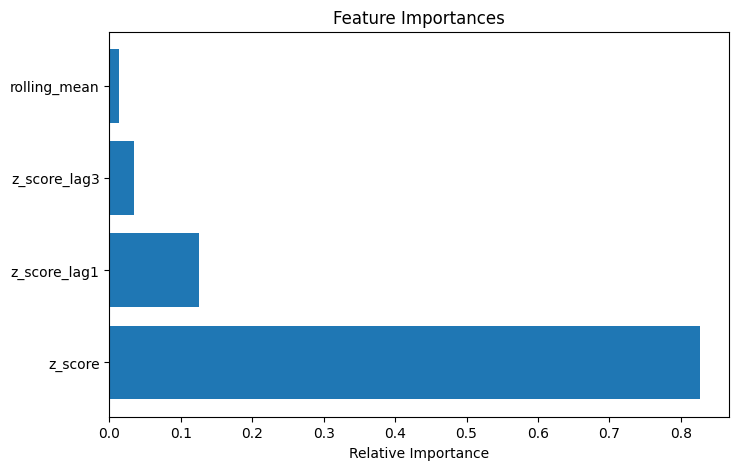

[0.01374963 0.03462874 0.12498004 0.8266416 ]


In [49]:
feature_importance(best_model_2,X_cut)